X_train.shape:  (364, 8, 44)
y_train.shape:  (364, 8)
X_test.shape:  (76, 8, 44)
y_test.shape:  (76, 8)
Epoch 1/100
19/19 [==============================] - 2s 25ms/step - loss: 14567.9912 - val_loss: 8333.5811
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 13534.5459 - val_loss: 7919.7285
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 13235.1631 - val_loss: 7764.2310
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 13053.9092 - val_loss: 7626.3872
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 12862.8779 - val_loss: 7497.5684
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 12704.0225 - val_loss: 7376.5078
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 12543.0879 - val_loss: 7261.4082
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 12406.1611 - val_loss: 7151.8350
Epoch 9/100
19/19 [============================

19/19 [==============================] - 0s 6ms/step - loss: 8951.6299 - val_loss: 5082.4829
Epoch 1/100
19/19 [==============================] - 4s 47ms/step - loss: 14273.4277 - val_loss: 7997.8115
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 12961.1318 - val_loss: 7342.5591
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 12400.9062 - val_loss: 7053.1851
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 12059.6211 - val_loss: 6813.4912
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 11761.5830 - val_loss: 6606.3247
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 11498.0449 - val_loss: 6423.3838
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 11259.8057 - val_loss: 6259.7803
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 11042.3604 - val_loss: 6112.7266
Epoch 9/100
19/19 [==============================] - 0s 8m

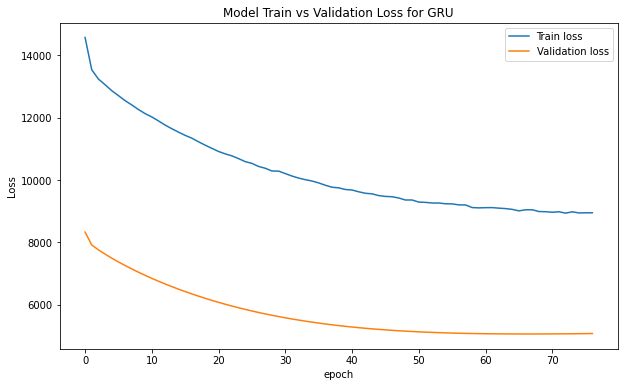

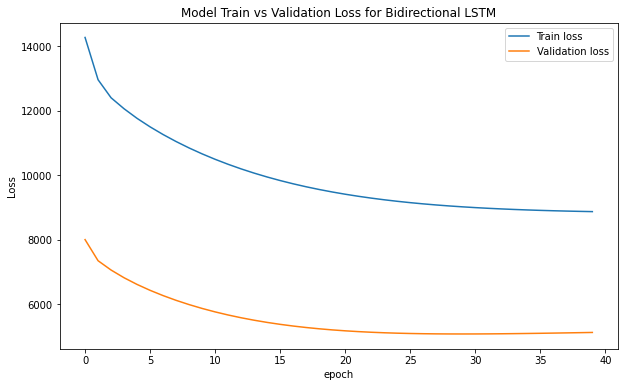

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

##########################################################
#Setting up the data frame

tf.random.set_seed(1234)
df = pd.read_csv("Data_climate_indices_V2.csv")
# print('Total num of missing values:')
# print(df.isna().sum())
df = df[df['date'] < '2020-01-01']
# print('Total num of missing values:')
# print(df.isna().sum())

######################################################
# Splitting data into test,train 
# train data upto : 2012
# test : 2012-2019
train_data = df[df['date'] < '2013-01-01']
test_data = df[df['date'] >= '2013-01-01']

######################################################
#Data transformation 

train_x = train_data.loc[:, train_data.columns != 'precipitation'] #features
train_x = train_x.loc[:, train_x.columns != 'date']

train_y = train_data['precipitation']

test_x = test_data.loc[:, test_data.columns != 'precipitation'] #features
test_x = test_x.loc[:, test_x.columns != 'date']

test_y = test_data['precipitation']


######################################################
#Input Creation 
                   
min_max_scaler = MinMaxScaler()

train_x_scaled = min_max_scaler.fit_transform(train_x)
test_x_scaled = min_max_scaler.fit_transform(test_x)

def create_dataset(X,Y,look_back = 8):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        
        Xs.append(X[i: i+look_back])
        ys.append(Y[i: i+look_back])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_x_scaled,train_y)
X_test, y_test = create_dataset(test_x_scaled, test_y)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)# Create GRU model

def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_gru = create_gru(64)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

# y_test = min_max_scaler.inverse_transform(y_test)
# y_train = min_max_scaler.inverse_transform(y_train)

def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')


def prediction(model):
    return model.predict(X_test)
    #prediction = scaler.inverse_transform(prediction)
    
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)


print("GRU",prediction_gru)
print("BILSTM", prediction_bilstm)



In [72]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
print(type(prediction_gru))
prediction_gru = prediction_gru.flatten()
prediction_bilstm = prediction_bilstm.flatten()
evaluate_prediction(prediction_gru, test_y[1:80], 'GRU')
evaluate_prediction(prediction_bilstm, test_y[1:80], 'Bidirectiona LSTM')

<class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (76,) (79,) 

In [74]:
obtainedResult = np.array([])
actualResult = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_gru) or a > len(prediction_gru)):
        break
    temp1 = prediction_gru[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResult = np.concatenate((obtainedResult, temp1))
    actualResult = np.concatenate((actualResult, temp2))
    


In [73]:
evaluate_prediction(obtainedResult, actualResult, 'Winter Range GRU')

Winter Range GRU:
Mean Absolute Error: 80.8873
Root Mean Square Error: 103.6586



In [75]:
obtainedResult = np.array([])
actualResult = np.array([])
a = 11
while True:
    
    if(a+5 > len(prediction_bilstm) or a > len(prediction_bilstm)):
        break
    temp1 = prediction_gru[a : a+5]
    temp2 = test_y[a : a+5]
    a = a + 11
    obtainedResult = np.concatenate((obtainedResult, temp1))
    actualResult = np.concatenate((actualResult, temp2))

In [67]:
evaluate_prediction(obtainedResult, actualResult, 'Winter Range GRU')

30 30
Winter Range GRU:
Mean Absolute Error: 80.8873
Root Mean Square Error: 103.6586

